In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from src.model.mask_unet import UNet
from src.libs.preprocessing import DataLoader
from src.libs.postprocessing import (
    get_unet,
    invert_spectrogram,
    upsample_spectrogram,
    Spectrogram,
)

from src.libs.visualization import plot_spectrograms

In [3]:
import os
os.chdir('../')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/Deep Learning et traitement du signal/projet_final/dlsp-denoising


## Load model and test data

In [5]:
post_name = "20241222_130207"
model_loaded = get_unet(post_name=post_name)

In [6]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [7]:
file_number = 5
test_x, test_y = harmonized_data.x[file_number], harmonized_data.y[file_number]

# Utils spectrogram

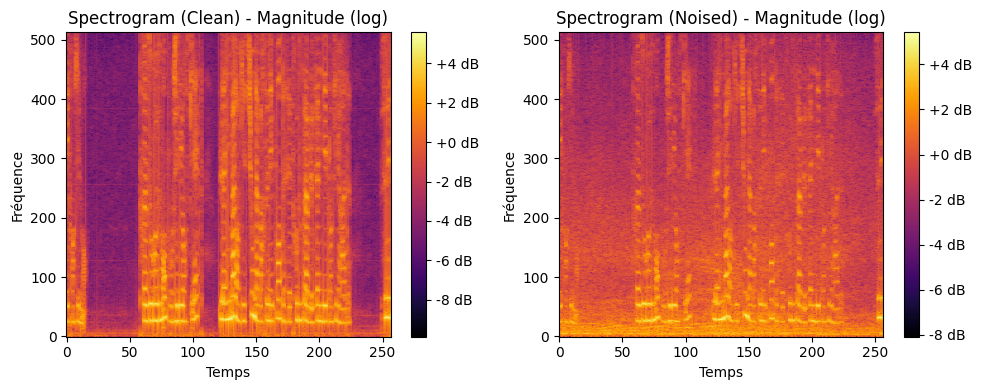

In [8]:
signal_clean = torch.tensor(test_y)
spect_clean = Spectrogram(signal_clean)

signal_noised = torch.tensor(test_x)
spect_noised = Spectrogram(signal_noised)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(
    spect_clean.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower"
)
axes[0].set_title("Spectrogram (Clean) - Magnitude (log)")
axes[0].set_xlabel("Temps")
axes[0].set_ylabel("Fréquence")
fig.colorbar(im0, ax=axes[0], format="%+2.0f dB")

im1 = axes[1].imshow(
    spect_noised.magnitude.numpy(), aspect="auto", cmap="inferno", origin="lower"
)
axes[1].set_title("Spectrogram (Noised) - Magnitude (log)")
axes[1].set_xlabel("Temps")
axes[1].set_ylabel("Fréquence")
fig.colorbar(im1, ax=axes[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()


# Invert a spectrogram without downsample and upsample

In [9]:
# Inverser le spectrogramme
reconstructed_signal = invert_spectrogram(
    spect_clean.spectrogam,
    n_fft=spect_clean.n_fft,
    hop_length=spect_clean.hop_length,
    win_length=spect_clean.win_length,
    length=spect_clean.signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal.shape}")

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal.numpy(), rate=8000)

Reconstructed Signal Shape: torch.Size([80000])


In [10]:
(reconstructed_signal - test_y).abs().max()

tensor(5.5511e-16, dtype=torch.float64)

# Upsample Spectrogram and inversion

In [11]:
spectrogram_downsampled = spect_clean.spectrogam[:-1, :-1]

spectrogram_aug = upsample_spectrogram(spectrogram_downsampled)
print(spectrogram_aug.shape, spectrogram_downsampled.shape)
reconstructed_signal_downsampled = invert_spectrogram(
    spectrogram_aug,
    n_fft=spect_clean.n_fft,
    hop_length=spect_clean.hop_length,
    win_length=spect_clean.win_length,
    length=spect_clean.signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal_downsampled.shape}")

print((reconstructed_signal_downsampled - reconstructed_signal).abs().std())

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal_downsampled.numpy(), rate=8000)

torch.Size([513, 257]) torch.Size([512, 256])
Reconstructed Signal Shape: torch.Size([80000])
tensor(0.0083, dtype=torch.float64)


# TEST PIPELINE EXAMPLE

In [12]:
post_name = "20241222_130207"
model_loaded = get_unet(post_name=post_name)

In [13]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [19]:
file_number = 3 # exemple où ça fonctionne moyen : 3, où ça fonctionne bien : 60
test_x, test_y = harmonized_data.x[file_number], harmonized_data.y[file_number]

## Listen Audio

In [20]:
spectrogram_noised = Spectrogram(torch.tensor(test_x))
mask = model_loaded(spectrogram_noised.magnitude[:-1, :-1].float()[None, None, :])
denoised_output = mask * spectrogram_noised.magnitude[:-1, :-1]
denoised_output_upsample = upsample_spectrogram(denoised_output)
denoised_output_upsample_complex = torch.exp(
    denoised_output_upsample + 1j * spectrogram_noised.angle
)[0, 0]
denoised_signal = invert_spectrogram(
    denoised_output_upsample_complex,
    n_fft=spectrogram_noised.n_fft,
    hop_length=spectrogram_noised.hop_length,
    win_length=spectrogram_noised.win_length,
    length=spectrogram_noised.signal.shape[0],
)
print("Signal bruité : ")
display(Audio(test_x, rate=harmonized_data.sampling_freq))

print("Signal débruité : ")
display(Audio(denoised_signal.detach().numpy(), rate=8000))

print("Signal target : ")
display(Audio(test_y, rate=harmonized_data.sampling_freq))

Signal bruité : 


Signal débruité : 


Signal target : 


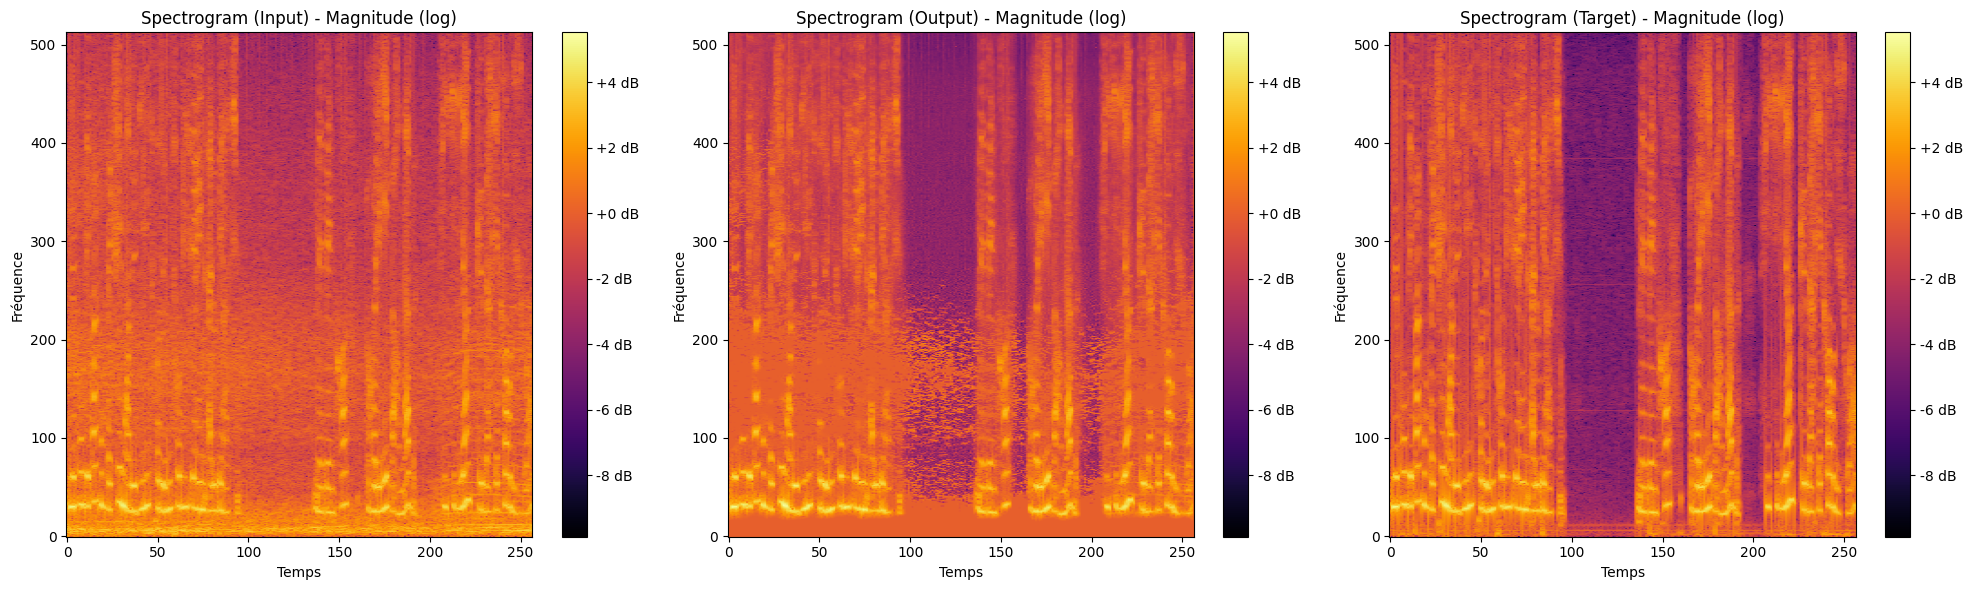

In [21]:
plot_spectrograms(test_x, denoised_output_upsample, test_y)

# Evaluation process 

In [22]:
from src.libs.evaluation import eval_all_signals, eval_signal 
from IPython.display import display, Audio
from tqdm import tqdm

In [23]:
post_name = "20241222_130207"
model_loaded = get_unet(post_name=post_name)

# Uniquement le test 
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


In [24]:
### Evaluation process
f_sampling = 8000
list_signals_pred = []

for file_nb in tqdm(range(len(harmonized_data.x))):
    test_x, test_y = harmonized_data.x[file_nb], harmonized_data.y[file_nb]
    spectrogram_noised = Spectrogram(torch.tensor(test_x))
    mask = model_loaded(spectrogram_noised.magnitude[:-1, :-1].float()[None, None, :])
    denoised_output = mask * spectrogram_noised.magnitude[:-1, :-1]
    denoised_output_upsample = upsample_spectrogram(denoised_output)
    denoised_output_upsample_complex = torch.exp(
        denoised_output_upsample + 1j * spectrogram_noised.angle
    )[0, 0]
    denoised_signal = invert_spectrogram(
        denoised_output_upsample_complex,
        n_fft=spectrogram_noised.n_fft,
        hop_length=spectrogram_noised.hop_length,
        win_length=spectrogram_noised.win_length,
        length=spectrogram_noised.signal.shape[0],
    )
    list_signals_pred.append(denoised_signal.detach().numpy())



100%|██████████| 608/608 [00:34<00:00, 17.71it/s]


In [25]:
def eval_all_signals(list_signals_pred, list_signals_target, f_sampling):
    " Iterations sur tous les signaux "
    MSE = []
    RMSE = []
    SNR = []
    STOI_results = []
    PESQ_results = []
    for i, signal_pred in tqdm(enumerate(list_signals_pred), total=len(list_signals_pred)):
        signal_target = list_signals_target[i]
        mse, rmse, snr, stoi_result, pesq_result = eval_signal(signal_pred, signal_target, f_sampling)
        MSE.append(mse)
        RMSE.append(rmse)
        SNR.append(snr)
        STOI_results.append(stoi_result)
        PESQ_results.append(pesq_result)
    return MSE, RMSE, SNR, STOI_results, PESQ_results


def summary_eval(MSE, RMSE, SNR, STOI_results, PESQ_results):
    print("Metric : mean (std)")
    print("___________________")
    print(f"MSE   : {np.mean(MSE):.4f} ({np.std(MSE):.4f})")
    print(f"RMSE  : {np.mean(RMSE):.4f} ({np.std(RMSE):.4f})")
    print(f"SNR   : {np.mean(SNR):.4f} ({np.std(SNR):.4f})")
    print(f"STOI  : {np.mean(STOI_results):.4f} ({np.std(STOI_results):.4f})")
    print(f"PESQ  : {np.mean(PESQ_results):.4f} ({np.std(PESQ_results):.4f})")

In [26]:
# Perfs après débruitage
MSE, RMSE, SNR, STOI_results, PESQ_results = eval_all_signals(list_signals_pred, harmonized_data.y, f_sampling)

100%|██████████| 608/608 [01:21<00:00,  7.48it/s]


In [27]:
summary_eval(MSE, RMSE, SNR, STOI_results, PESQ_results)

Metric : mean (std)
___________________
MSE   : 0.0014 (0.0009)
RMSE  : 0.0367 (0.0096)
SNR   : 11.0081 (1.6416)
STOI  : 0.9265 (0.0737)
PESQ  : 2.6744 (0.6221)


In [28]:
# Perfs avant débruitage
MSE_baseline, RMSE_baseline, SNR_baseline, STOI_results_baseline, PESQ_results_baseline = eval_all_signals(harmonized_data.x, harmonized_data.y, f_sampling)
summary_eval(MSE_baseline, RMSE_baseline, SNR_baseline, STOI_results_baseline, PESQ_results_baseline)

100%|██████████| 608/608 [01:23<00:00,  7.30it/s]

Metric : mean (std)
___________________
MSE   : 0.0031 (0.0035)
RMSE  : 0.0474 (0.0292)
SNR   : 10.2602 (5.5051)
STOI  : 0.9279 (0.0711)
PESQ  : 2.5848 (0.6462)


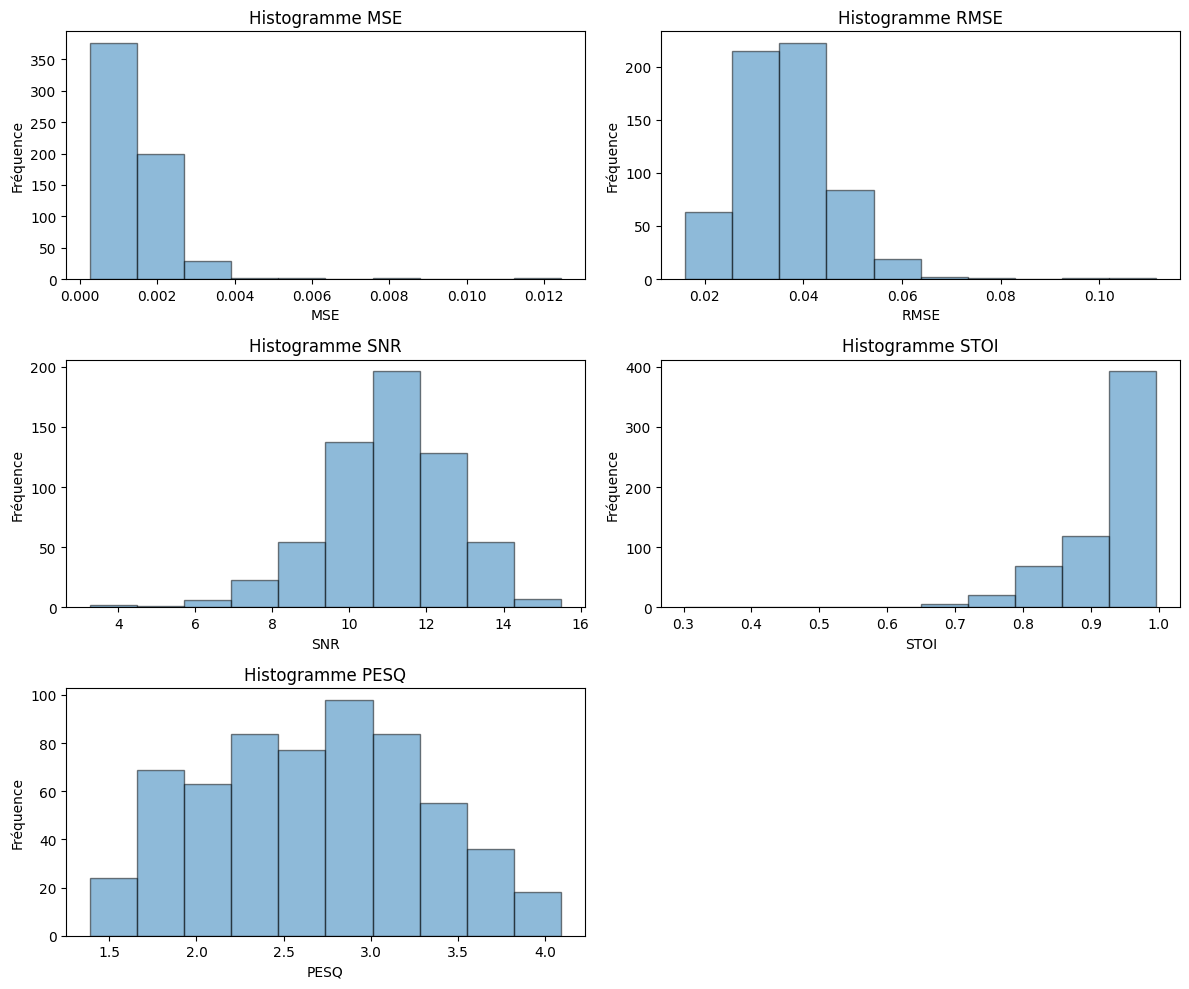

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=10, edgecolor='black', alpha=0.5)
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=10, edgecolor='black', alpha=0.5)
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=10, edgecolor='black', alpha=0.5)
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=10, edgecolor='black', alpha=0.5)
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=10, edgecolor='black', alpha=0.5)
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

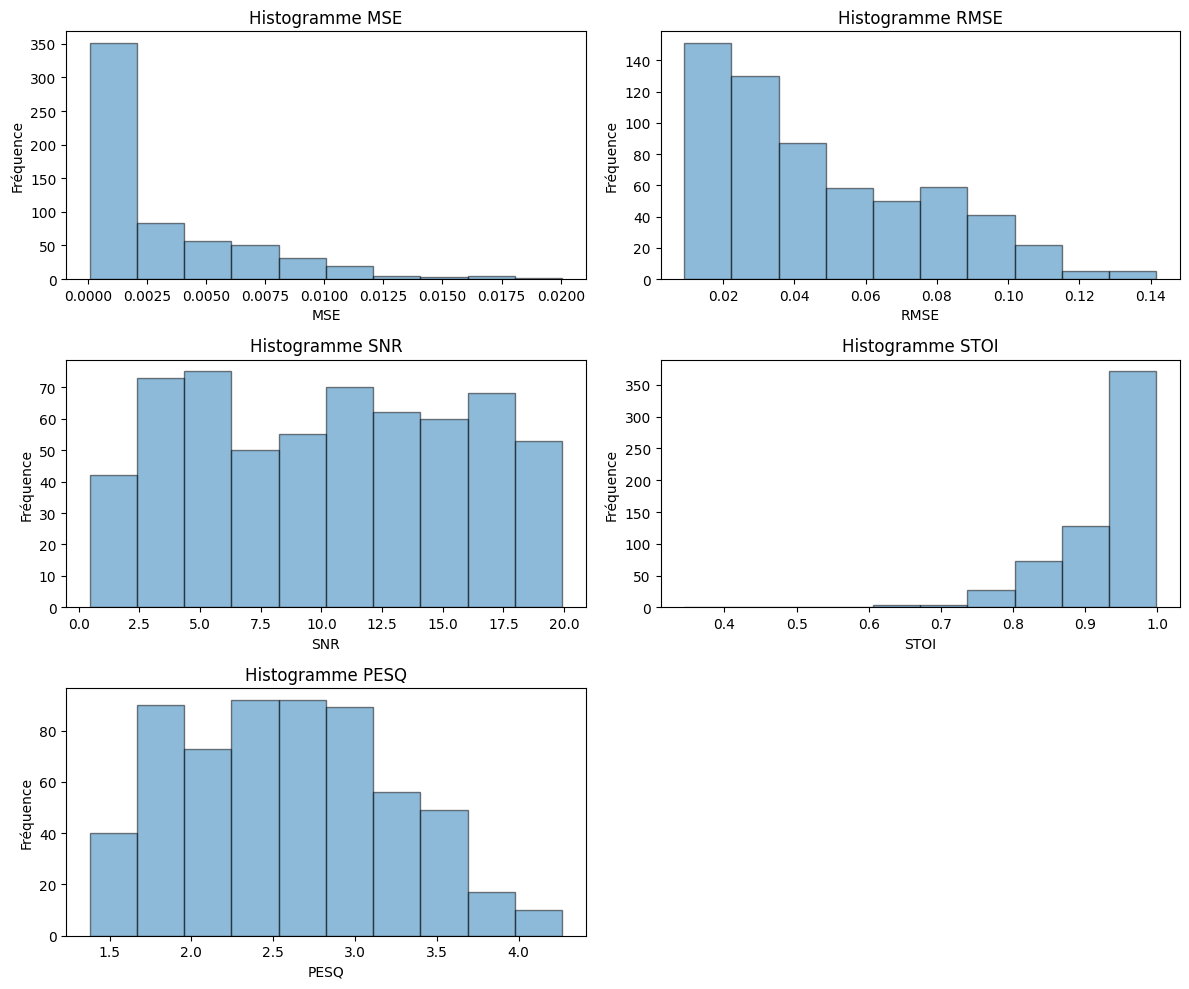

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE_baseline, bins=10, edgecolor='black', alpha=0.5)
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE_baseline, bins=10, edgecolor='black', alpha=0.5)
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR_baseline, bins=10, edgecolor='black', alpha=0.5)
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results_baseline, bins=10, edgecolor='black', alpha=0.5)
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results_baseline, bins=10, edgecolor='black', alpha=0.5)
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()